# NOTE TO SELF

After a lot of different attempts, I believe that for the purpose of this single ROI decoding in which everything takes place within nimare world, we do not need to either write the individual topic maps to disk or to flip them. 

The code for flipping is in S15a. Code for decoding based on flip S15b. No flip, but flipped atlas S15c. I believe there is no need for these extra steps, that alghouh slightly change the p-values, it does not change the top topics and wordcloud... and therefore interpretation

May 13th, 2024

In [1]:
from utils.basics import RESOURCES_NIMARE_DIR, ATLASES_DIR, FB_400ROI_ATLAS_NAME, PRJ_DIR, SCRIPTS_DIR, RESOURCES_NBS_DIR
from utils.plotting import create_graph_from_matrix
import os
import os.path as osp
import nibabel as nib
from nilearn.image import load_img
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import masking
import numpy as np
import pandas as pd
from utils.basics import FB_400ROI_ATLAS_PATH
import subprocess
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap

import getpass
from datetime import datetime
from glob import glob

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
import nilearn
print (nilearn.__version__)

0.10.1


In [3]:
from nimare.decode import discrete
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
import nimare
print(nimare.__version__)

0.2.1


In [4]:
import wordcloud
print(wordcloud.__version__)

1.8.2.2


In [5]:
def my_orange_color_func(dictionary):
    def my_orange_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Oranges',100).as_hex()
        return color_list[freq_as_int]
    return my_orange_color_func_inner
def my_blue_color_func(dictionary):
    def my_blue_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
        freq_as_int = int(dictionary[word])
        color_list = sns.color_palette('Blues',100).as_hex()
        return color_list[freq_as_int]
    return my_blue_color_func_inner

# 1. NiMare Setup
## 1.1. Folder Setup

In [6]:
VOCAB = 'LDA50'
ATLAS_NAME = FB_400ROI_ATLAS_NAME

In [7]:
VOCAB_DIR            = osp.join(RESOURCES_NIMARE_DIR,VOCAB)
METAMAPS_ORIG_DIR    = osp.join(VOCAB_DIR,"meta-analyses-orig")  # where to save meta-analysis maps
METAMAPS_RPI_DIR     = osp.join(VOCAB_DIR,"meta-analyses-RPI")  # where to save meta-analysis maps

ns_dset_path         = osp.join(VOCAB_DIR, f"neurosynth_dataset_{VOCAB}.pkl.gz")
ns_dset_mask_path    = osp.join(VOCAB_DIR, f"neurosynth_dataset_{VOCAB}_mask.nii")

print('++ INFO: Resource Folder for NiMare Analyses                              : %s' % RESOURCES_NIMARE_DIR)
print('++ INFO: Folder for this vocabulary                                       : %s' % VOCAB_DIR)
print('++ INFO: Folder for meta-maps in original orientation as written by NiMare: %s' % METAMAPS_ORIG_DIR)
print('++ INFO: Folder for meta-maps in RPI orientation (the one our data has)   : %s' % METAMAPS_RPI_DIR)
print('++ ------------------------------------------------------------------------')
print('++ INFO: Path for NeuroSynth Dataset in NiMare format                     : %s' % ns_dset_path)
print('++ INFO: Path for NeuroSynth Dataset mask                                 : %s' % ns_dset_mask_path)
#print('++ INFO: Path for locally trained LDA model.                              : %s' % lda_model_path)

++ INFO: Resource Folder for NiMare Analyses                              : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare
++ INFO: Folder for this vocabulary                                       : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50
++ INFO: Folder for meta-maps in original orientation as written by NiMare: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig
++ INFO: Folder for meta-maps in RPI orientation (the one our data has)   : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI
++ ------------------------------------------------------------------------
++ INFO: Path for NeuroSynth Dataset in NiMare format                     : /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz
++ INFO: Path for NeuroSyn

In [8]:
FB_400ROI_ATLAS_ORIG_GRID_FILE   = osp.join(FB_400ROI_ATLAS_PATH,f'{ATLAS_NAME}.nii.gz')
FB_400ROI_ATLAS_NIMARE_GRID_FILE = osp.join(RESOURCES_NIMARE_DIR,f'{ATLAS_NAME}_NiMareGrid.nii.gz')
NIMARE_DECODING_RIBBON_MASK      = osp.join(RESOURCES_NIMARE_DIR,'NiMare_Decoding_Mask_GMribbon.nii.gz')

In [9]:
# Create Empty Output Folders
# ===========================
print("++ INFO: Setting up all necessary folders")
for folder_path in [RESOURCES_NIMARE_DIR, VOCAB_DIR, METAMAPS_ORIG_DIR, METAMAPS_RPI_DIR]:
    if osp.exists(folder_path):
        print(" + WARNING: Removing folder [%s]" % folder_path)
        shutil.rmtree(folder_path)
    print(" + INFO: Generating/Regenerating output folder [%s]" % folder_path)
    os.mkdir(folder_path)

++ INFO: Setting up all necessary folders
 + WARNING: Removing folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-orig]
 + INFO: Generating/Regenerating output folder [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/meta-analyses-RPI]


## 1.2. Download Neurosynth 7 database

First, we need to download the Neurosynth database (version 7) for the 50 Topic Vocabulary

In [10]:
# Download NeuroSynth database
print("++ INFO: Fetching neurosynth dataset for this vocabulary...")
neurosynth_db = fetch_neurosynth(data_dir=VOCAB_DIR, version="7", overwrite=False, vocab=VOCAB, source="abstract")[0]

INFO:nimare.extract.utils:Dataset created in /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('vocab-LDA50', 'source-abstract', 'data-neurosynth', 'version-7')]


++ INFO: Fetching neurosynth dataset for this vocabulary...


In [11]:
#neurosynth_db['coordinates'] = '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/n/data-neurosynth_version-7_metadata.NOUNKNOWN.tsv'
neurosynth_db

{'coordinates': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-neurosynth_version-7_coordinates.tsv.gz',
 'metadata': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-neurosynth_version-7_metadata.tsv.gz',
 'features': [{'features': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-neurosynth_version-7_vocab-LDA50_source-abstract_type-weight_features.npz',
   'vocabulary': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-neurosynth_version-7_vocab-LDA50_vocabulary.txt',
   'keys': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-neurosynth_version-7_vocab-LDA50_keys.tsv',
   'metadata': '/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth/data-ne

## 1.3. Convert Neurosynth Database to NiMare Dataset

Next, we need to convert it into a format NiMare can understand

In [12]:
%%time
# Convert to NiMare Dataset
neurosynth_dset           = convert_neurosynth_to_dataset(
        coordinates_file  = neurosynth_db['coordinates'],
        metadata_file     = neurosynth_db['metadata'],
        annotations_files = neurosynth_db['features'],
        target            = 'mni152_2mm')

CPU times: user 2min 40s, sys: 2.88 s, total: 2min 43s
Wall time: 2min 39s


In [13]:
neurosynth_dset.coordinates

,id,study_id,contrast_id,x,y,z,space
1483,10022492-1,10022492,1,36.0,-58.0,52.0,mni152_2mm
1499,10022492-1,10022492,1,48.0,24.0,20.0,mni152_2mm
1498,10022492-1,10022492,1,-42.0,26.0,20.0,mni152_2mm
1497,10022492-1,10022492,1,-36.0,30.0,16.0,mni152_2mm
1496,10022492-1,10022492,1,-30.0,32.0,0.0,mni152_2mm
...,...,...,...,...,...,...,...
1479,9990082-1,9990082,1,42.0,-54.0,-21.0,mni152_2mm
1480,9990082-1,9990082,1,-36.0,-87.0,-6.0,mni152_2mm
1481,9990082-1,9990082,1,30.0,-81.0,-15.0,mni152_2mm
1467,9990082-1,9990082,1,-18.0,-60.0,54.0,mni152_2mm


To avoid having to do these two steps continously, we will save the NiMare version of the NeuroSynth Database to disk. If we need it again, we just have to load this file.

In [14]:
# Save the dataset as a pickle file to the Resources directory
print ("++ INFO: Saving NeuroSynth Dataset to disk: %s" % ns_dset_path)
neurosynth_dset.save(ns_dset_path)

++ INFO: Saving NeuroSynth Dataset to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50.pkl.gz


As a sanity check, we print the labels for the first 10 topics and count how many topics in total are in the database.

In [15]:
# Extract Topic Names
topics_ORIG = neurosynth_dset.get_labels()
print('++ INFO: First few topics      : %s' % str(topics_ORIG[0:5]))
print('++ INFO: Total number of topics: %d' % len(topics_ORIG))

++ INFO: First few topics      : ['LDA50_abstract_weight__0_network_state_resting', 'LDA50_abstract_weight__1_anxiety_trait_personality', 'LDA50_abstract_weight__2_cerebellar_cerebellum_basal', 'LDA50_abstract_weight__3_cortex_anterior_cingulate', 'LDA50_abstract_weight__4_stimulus_time_repetition']
++ INFO: Total number of topics: 50


## 1.4. Extract Dset Mask

This is necessary to ensure that any dataset that we decode is sitting on the same space and grid that NiMare expects

In [16]:
nib.save(neurosynth_dset.masker.mask_img,ns_dset_mask_path)
print('++ INFO: Neurosynth Dataset mask saved to disk: %s' % ns_dset_mask_path)

++ INFO: Neurosynth Dataset mask saved to disk: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii


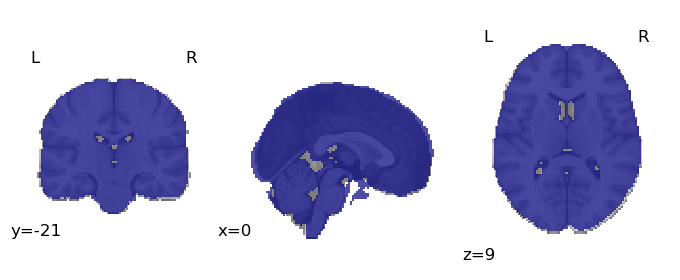

In [17]:
dset_mask = load_img(ns_dset_mask_path)
plot_roi(dset_mask, draw_cross=False);

In [18]:
command = f'''module load afni; \
              3dinfo -space -orient -header_name -header_line {ns_dset_mask_path}; \
        '''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-14

space	=dim?	all_nms
MNI	LPI	/gpfs/gsfs11/users/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/LDA50/neurosynth_dataset_LDA50_mask.nii


## 1.5. Make a mask restricted to GM ribbon for decoding

Although it is possible to decode using a full brain mask, this tends to not work so well becuase WM voxels cloud the correlations. 

First, we create a version of the atlas (Which covers the GM ribbon) in the same grid as the mask file provided by nimare. which as you can see above is a full brain mask

In [19]:
command = f'''module load afni; \
              3dresample -overwrite -rmode NN \
                         -input  {FB_400ROI_ATLAS_ORIG_GRID_FILE} \
                         -prefix {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -master {ns_dset_mask_path}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())
print('++ New File: %s' % FB_400ROI_ATLAS_NIMARE_GRID_FILE)

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-14
++ New File: /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/Schaefer2018_400Parcels_7Networks_AAL2_NiMareGrid.nii.gz


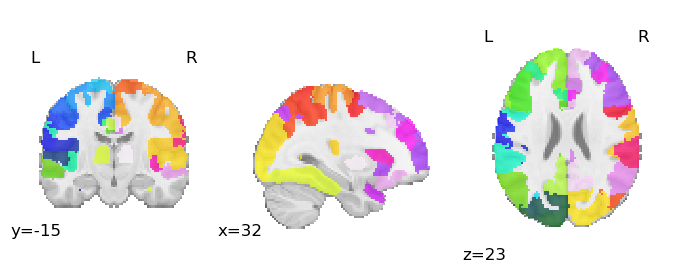

In [20]:
atlas_img = load_img(FB_400ROI_ATLAS_NIMARE_GRID_FILE)
plot_roi(atlas_img, draw_cross=False)

Create final mask for decoding (Neurosynth grid but restricted to the GM ribbon on which we computed the CPCAs)

In [21]:
command = f'''module load afni; \
              3dcalc -overwrite \
                         -a {FB_400ROI_ATLAS_NIMARE_GRID_FILE} \
                         -b {ns_dset_mask_path} \
                         -expr "step(a)*b" \
                         -prefix {NIMARE_DECODING_RIBBON_MASK}'''
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-14

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NiMare_Decoding_Mask_GMribbon.nii.gz


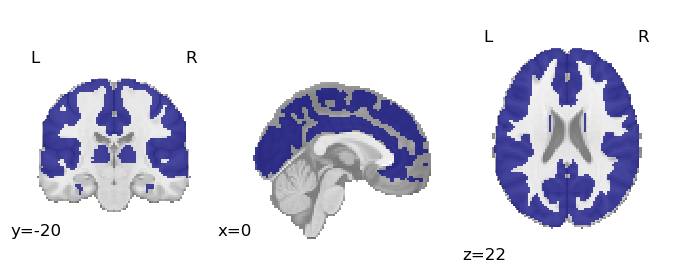

In [22]:
ribbon_mask_img = load_img(NIMARE_DECODING_RIBBON_MASK)
plot_roi(ribbon_mask_img, draw_cross=False)

# 2. Extract ROIs with highest degree for both NBS contrasts

# 2.1. Load Atlas Information so that we can annotate Pandas Dataframes

In [23]:
NBS_THRESHOLD        = 'NBS_3p1'
DESIGN_MATRIX        = 'SbjAware'
NBS_CONTRASTS = ['Image-Pos-Others_gt_Surr-Neg-Self','Surr-Neg-Self_gt_Image-Pos-Others']

In [24]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,'{ATLAS_NAME}.roi_info.csv'.format(ATLAS_NAME=ATLAS_NAME))
roi_info       = pd.read_csv(ATLASINFO_PATH)
Nrois          = roi_info.shape[0]

## 2.2. Load NBS Results

Load the connections that are significantly stronger for the contrast: $$Image-Pos-Others > Surr-Neg-Self$$
and the contrast: $$Surr-Neg-Self > Image-Pos-Others$$

In [25]:
NBS_constrasts = {}
for contrast in NBS_CONTRASTS:
    aux_path = osp.join(RESOURCES_NBS_DIR,ATLAS_NAME,f'NBS_CL02_Results',NBS_THRESHOLD,DESIGN_MATRIX,f'NBS_CL02_{contrast}.edge')
    if osp.exists(aux_path):
        aux_data = np.loadtxt(aux_path)
        NBS_constrasts[contrast]  = pd.DataFrame(aux_data,
                                         index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                         columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
        print('++ INFO: Data available for %s' % contrast)
    else:
        NBS_constrasts[contrast] = pd.DataFrame(np.zeros((Nrois,Nrois)),
                                     index   = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index, 
                                     columns = roi_info.set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).index)
        print('++ WARTNING: No results available for %s' % contrast)

++ WARTNING: No results available for Image-Pos-Others_gt_Surr-Neg-Self
++ INFO: Data available for Surr-Neg-Self_gt_Image-Pos-Others


## 2.3. Create Graph Models needed to compute Degree

In [26]:
%%time
NBS_Gs,NBS_Gatts = {},{}
for contrast in NBS_constrasts.keys():
    # Create Graph Model
    NBS_Gs[contrast],NBS_Gatts[contrast]      = create_graph_from_matrix(NBS_constrasts[contrast])
    NBS_Gatts[contrast] =  NBS_Gatts[contrast].set_index(['Hemisphere','Network','ROI_Name','ROI_ID','RGB']).sort_index(level='ROI_ID')
N_rois = NBS_Gatts[contrast].shape[0]
print('++ INFO: Number of ROIs: %d' % N_rois)

++ INFO: Number of ROIs: 380
CPU times: user 188 ms, sys: 901 µs, total: 189 ms
Wall time: 190 ms


## 2.4. Write Graph Metric-per-ROI Results to disk as NifTi Files

We load the atlas (the version on the grid that aligns with NiMare) as a vector.

In [27]:
atlas_vector = masking.apply_mask(FB_400ROI_ATLAS_NIMARE_GRID_FILE, ns_dset_mask_path)
print('++ INFO: Atlas Dimensions as a vector = %s' % str(atlas_vector.shape))

++ INFO: Atlas Dimensions as a vector = (228483,)


++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Image-Pos-Others_gt_Surr-Neg-Self_Degree.nii]


/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/find_cuts.py:69: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Image-Pos-Others_gt_Surr-Neg-Self_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Image-Pos-Others_gt_Surr-Neg-Self_Page_Rank.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Degree.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Eigenvector_Centrality.nii]
++ INFO: File written to disk [/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Page_Rank.nii]
CPU times: user 7.02 s, sys: 775 ms, total: 7.79 s
Wall time: 6.48 

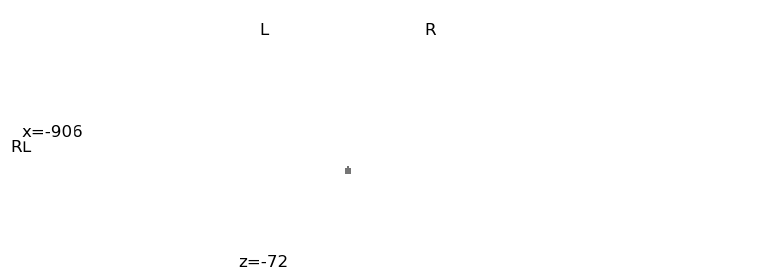

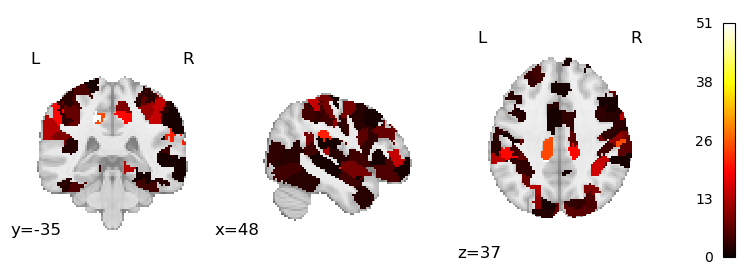

In [28]:
%%time
for contrast in NBS_constrasts.keys():
    for metric in ['Degree','Eigenvector_Centrality','Page_Rank']:
        # Create Empty Vector with same dimensions as atlas
        output_vector = np.zeros(atlas_vector.shape)
        # For each ROI extract the Graph Metric of interest
        for hm,nw,roi_name,roi_id,rgb in NBS_Gatts[contrast].index:
            output_vector[atlas_vector==roi_id] = NBS_Gatts[contrast].loc[(hm,nw,roi_name,roi_id,rgb),metric]
        # Write to disk just in case we want to look at it later
        output_img = masking.unmask(output_vector,ns_dset_mask_path)
        output_path = osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_{metric}.nii')
        output_img.to_filename(output_path)
        print('++ INFO: File written to disk [%s]' % output_path)
        if metric == 'Degree':
            plot_stat_map(output_path, draw_cross=False)

## 2.5. Also write file for the top degree ROI for each contrast (this is the one we will decode)

In [29]:
NBS_constrasts[contrast].sum().sort_values(ascending=False).reset_index(drop=True).hvplot()

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type
/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/holoviews/core/data/pandas.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return dataset.data.dtypes[idx].type


:Curve   [index]   (0)

In [30]:
for contrast in NBS_constrasts.keys():
    if NBS_constrasts[contrast].sum().sum() == 0.0:
        continue
    aux = NBS_constrasts[contrast].sum().sort_values(ascending=False)[0:3]
    print(contrast)
    print(aux)
    for roi_id, file_label in zip(aux.index.get_level_values('ROI_ID'),['TopROI','SecondROI','ThirdROI']):
        out_path = osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_Degree_{file_label}.nii')
        print(roi_id,file_label, out_path)
        command = f'''
                   module load afni;\
                   3dcalc -overwrite -a {FB_400ROI_ATLAS_ORIG_GRID_FILE} -expr "equals(a,{roi_id})" -prefix {out_path};
                   '''
        output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        print(output.strip().decode())

Surr-Neg-Self_gt_Image-Pos-Others
Hemisphere  Network      ROI_Name              ROI_ID  RGB    
LH          SalVentAttn  LH_SalVentAttn_Med_5  111     #c53afd    51.0
                         LH_SalVentAttn_Med_3  109     #c53afb    24.0
RH          DorsAttn     RH_DorsAttn_Post_6    267     #04770c    24.0
dtype: float64
111 TopROI /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Degree_TopROI.nii
[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-05-14

++ 3dcalc: AFNI version=AFNI_24.1.11 (May 10 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Degree_TopROI.nii
109 SecondROI /data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Degree_SecondR

# 3. Preparations for WordCloud & ROI plot generation

Neurosynth topics and terms contain words that are not necessarily that meaningful when looking for relationships to cognitive processes. Examples of such words include those about anatomical structures, anatomical location, tissue types, imaging modalities, etc. We will remove those prior to generating wordclouds

In [31]:
my_stopwords = list(STOPWORDS) + ['resonance','magnetic','medial','lateral','dorsal','ventral','anterior','posterior','primary','secondary',
                                  'contralateral','prefrontal','temporal','occipital','parietal','frontal','network','cortex',
                                  'sii','mns','neuron','pre','md','gm','volume','matter','white','gray','hemispheric','state','mpfc','dmn','default',
                                  'fc','rest', 'temporoparietal','hippocampus','insula','premotor','supplementary','resting']

In this study we work with the 50 Topic dictionary. Each topic is associated with a set of terms that appear in unison in the neuroimaing literature. The next cell gathers the 40 top terms associated with each topic. We will only pick only those assoicated with topics that show significant correlations with our ROIs later when generating wordclouds. For now we load them all and have then ready on a pandas dataframe.

In [16]:
from nimare.dataset import Dataset
neurosynth_dset = Dataset.load(ns_dset_path)

In [32]:
if VOCAB != 'terms':
    path            = osp.join(VOCAB_DIR,'neurosynth',f'data-neurosynth_version-7_vocab-{VOCAB}_keys.tsv')
    words_per_topic = pd.read_csv(path, sep='\t', header=None)
    words_per_topic.index = neurosynth_dset.get_labels()
    words_per_topic.index.name = 'Topic Label'
    words_per_topic.columns = ['Topic ID','Unknown','Terms']
    words_per_topic.head(5)

Finally, we will want to show the ROI with the highest degree on each direction of the contrast. To make nilearn plot the countour in black color, we need to generate a fake colormap with black being the first color.

In [33]:
roi_cmap = LinearSegmentedColormap.from_list('black',['#000000','#ffffff'],10)

# 4. ROI decoding on location with highest degree

## 4.1. Images-Pos-Others > Surr-Neg-Self

### 4.1.1. Load the target ROI

In [41]:
contrast = 'Image-Pos-Others_gt_Surr-Neg-Self'
top_degree_roi_path =  osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_Degree_TopROI.nii')
if not osp.exists(top_degree_roi_path):
    print("++ WARNING: Nothing was significant --> No decoding to be done for %s" % contrast)
else:
    top_degree_roi      = load_img(top_degree_roi_path)

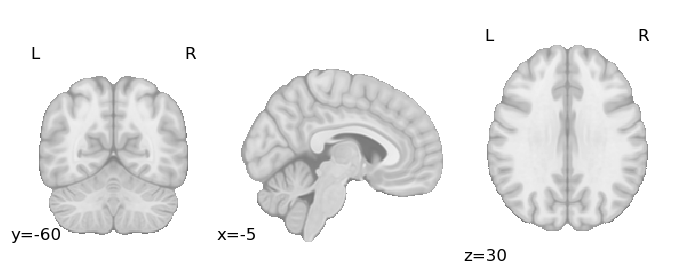

In [43]:
f = plot_roi(top_degree_roi,draw_cross=False, display_mode='ortho', cut_coords=[-5,-60,30], linewidths=3, view_type='contours', cmap=roi_cmap)

In [30]:
f.savefig(f'./figures/S15_{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_TopDegree_ROI.png')

### 4.1.2. Gather the studies with coordinates that overlap with the ROI

In [31]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 283 stduies


### 4.1.3. Decode using the Chi-Method

In [32]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nimare/decode/discrete.py:600: RuntimeWarning: invalid value encountered in divide
  p_selected_g_noterm = n_selected_noterm / n_noterm


In [33]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
LDA50_abstract_weight__32_pain_somatosensory_stimulation,1.000000e+00,-0.000000,0.030128,1.995451e-08,5.612395,0.710873
LDA50_abstract_weight__17_motor_cortex_hand,5.944950e-11,6.545115,0.023831,7.472164e-10,6.155753,0.685660


### 4.1.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [34]:
if VOCAB != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [35]:
freqs_df = pd.Series(dtype=float)
if VOCAB == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [36]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [37]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [38]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

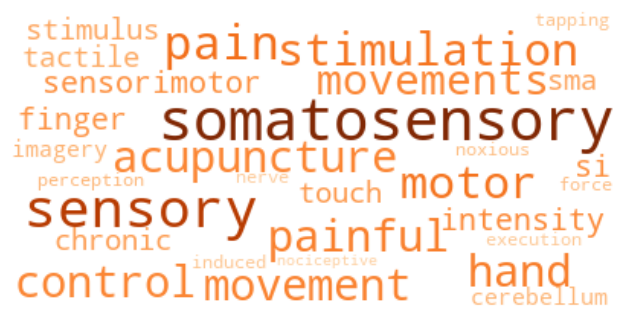

In [39]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_orange_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S15_WordCloud_{NBS_THRESHOLD}_{contrast}_TopDegree_NeuosynthDeconding.png')

## 4.2. Surr-Neg-Self > Images-Pos-Others

### 4.2.1. Load the target ROI

In [41]:
contrast = 'Surr-Neg-Self_gt_Image-Pos-Others'
top_degree_roi_path =  osp.join(RESOURCES_NIMARE_DIR,f'{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_Degree_SecondROI.nii')
print(top_degree_roi_path)
if not osp.exists(top_degree_roi_path):
    print("++ WARNING: Nothing was significant --> No decoding to be done for %s" % contrast)
else:
    top_degree_roi      = load_img(top_degree_roi_path)

/data/SFIMJGC_Introspec/2023_fc_introspection/code/fc_introspection/resources/nimare/NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_Degree_SecondROI.nii


/data/SFIMJGC_HCP7T/Apps/envs/fc_introspection_2023_py310/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


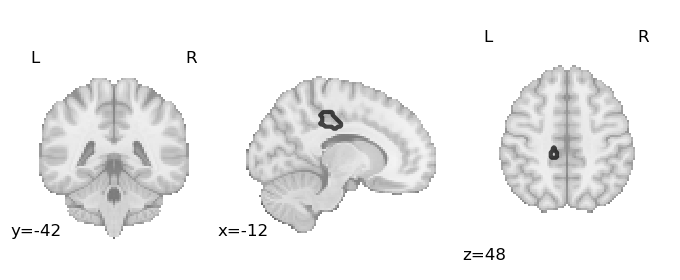

In [42]:
f = plot_roi(top_degree_roi,draw_cross=False, cut_coords=[-12,-42,48], display_mode='ortho', linewidths=3, view_type='contours', cmap=roi_cmap) #cut_coords=[-61,-36,33], 

In [43]:
fig_path = f'./figures/S15_{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_TopDegree_ROI.png'
f.savefig(fig_path)
print(fig_path)

./figures/S15_NBS_3p1_SbjAware_Surr-Neg-Self_gt_Image-Pos-Others_TopDegree_ROI.png


### 4.2.2. Gather the studies with coordinates that overlap with the ROI

In [44]:
# Get studies with voxels in the mask
ids = neurosynth_dset.get_studies_by_mask(top_degree_roi)
print('++INFO: Number of studies that overlap with the ROI: %d stduies' % len(ids))

++INFO: Number of studies that overlap with the ROI: 377 stduies


In [45]:
neurosynth_dset.get_metadata(ids[0])

['authors', 'journal', 'year', 'title']

### 4.2.3. Decode using the Chi-Method

In [46]:
# Run the decoder
decoder = discrete.NeurosynthDecoder(u=0.05, correction='bonferroni')
decoder.fit(neurosynth_dset)
decoded_df = decoder.transform(ids=ids)

In [47]:
selected_topics = decoded_df[decoded_df['pReverse']<0.05].sort_values(by='probReverse', ascending=False)
print('++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)')
selected_topics

++ List of topics that correlate significantly with the provided ROI (pBONF<0.05)


,pForward,zForward,probForward,pReverse,zReverse,probReverse
Term,,,,,,
LDA50_abstract_weight__19_action_actions_observation,1.0,-0.0,0.032152,0.006157,2.73931,0.621694


### 4.2.4. Generate a wordcloud

If we are not dealing with terms directly, which is the case with the topic dictionaries, we need to first create a dictionary with the invidual terms assoicated with each topic.

That dictorionary will contain the term, and a weight that corresponds to the inverse rank of the term within the topic. As we consider only the top 40 terms associated with each topic (what Neurosynth makes available), weights will be integers in the range 1 to 40.

In [37]:
if VOCAB != 'terms':
    term_weights_per_topic={}
    for topic in words_per_topic.index:
        this_topic_words              = words_per_topic.loc[topic]['Terms']
        this_topic_words_top40        = this_topic_words.split(' ')[0:40][::-1]
        term_weights_per_topic[topic] = {word:weight+1 for weight,word in enumerate(this_topic_words_top40)}

Next, to generate final weights per term used in the wordcloud formation, we will multiply each term by the reverse probability of the topic to which they belong. Then for each term we will compute the final weight as the sum of all such topic specific weights (just in case a term appears in more than one selected topic.)

In [38]:
freqs_df = pd.Series(dtype=float)
if VOCAB == 'terms':
    for term_long,row in selected_topics.iterrows():
        term = term_long.split('__')[1]
        term_prob = row['probReverse']
        if term in freqs_df.index:
            freqs_df[term] = freqs_df[term] + term_prob
        else:
            freqs_df[term] = term_prob
else:
    for topic in selected_topics.index:
        this_topic_prob = selected_topics.loc[topic,'probReverse']
        for word,weight in term_weights_per_topic[topic].items():
            if word in freqs_df.index:
                freqs_df[word] = freqs_df[word] + (this_topic_prob * weight)
            else:
                freqs_df[word] = (this_topic_prob * weight)

Finally, we will select the top 30 terms for the wordcloud. Size of words will be directly related to the weights. In addition, to make sure color of the words is also associated with the weights, we need to do a bit more meddling so that we can crease a color scale that gives more emphasis (e.g., darker colors) to the terms with the highest weights, yet other words also have an intesnsity that allows us to read the words.

In [39]:
freqs_df.drop(my_stopwords,errors='ignore', inplace=True)
freqs_df  = freqs_df.sort_values(ascending=False)[0:30]

In [40]:
# Compute values constrained between 0 and 100 (ONLY FOR COLORSCALE PURPOSES)
freqs_arr = freqs_df.values
freqs_arr = freqs_arr.reshape(-1,1)
freqs_arr = MinMaxScaler((25,99)).fit_transform(freqs_arr)
freqs_df_color = pd.Series(freqs_arr.flatten(),index=freqs_df.index)

As the wordcloud API takes as inputs dictonaries, we will transform the dataframes with the weights for word_size and word_color to python dictionary structures

In [41]:
freqs_dict = freqs_df.to_dict()
freqs_color_dict = freqs_df_color.to_dict()

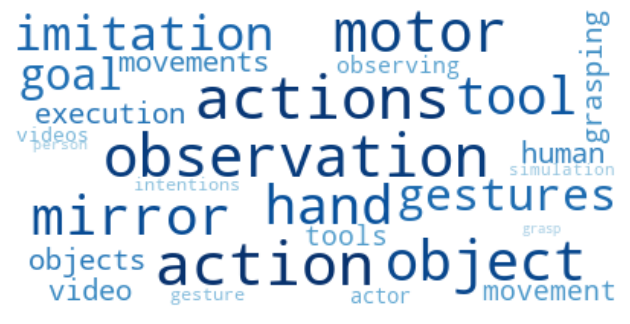

In [42]:
wc = WordCloud(max_font_size=40,min_font_size=9, stopwords=set(my_stopwords),
                   contour_color='black', contour_width=3, 
                   background_color='white', color_func=my_blue_color_func(freqs_color_dict),
                   repeat=False).generate_from_frequencies(freqs_dict )
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'./figures/S15_WordCloud_{NBS_THRESHOLD}_{DESIGN_MATRIX}_{contrast}_TopDegree_NeuosynthDeconding.png')

<Figure size 640x480 with 0 Axes>